In [ ]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Iteration 9: 100%|██████████| 50/50 [00:14<00:00,  3.53it/s, episode=500, return=0.289, uncertainty_matrix=0.675, avg_steps=64.0]


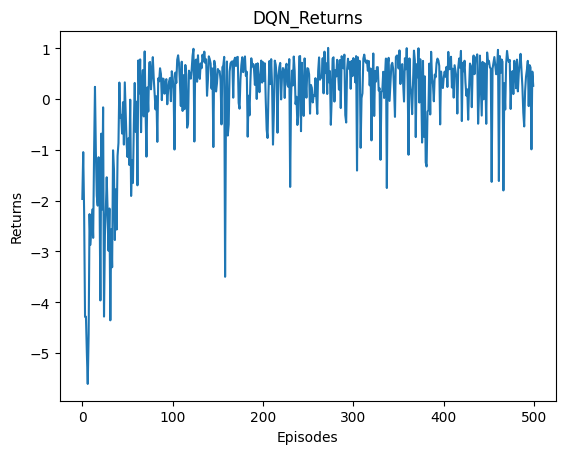

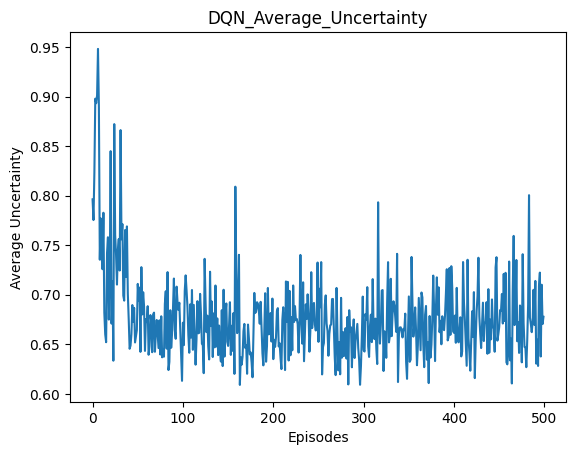

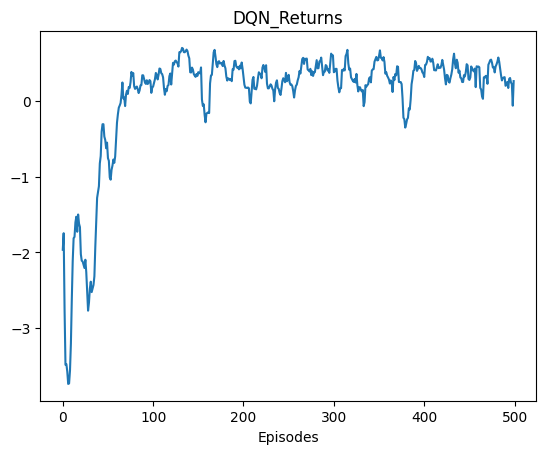

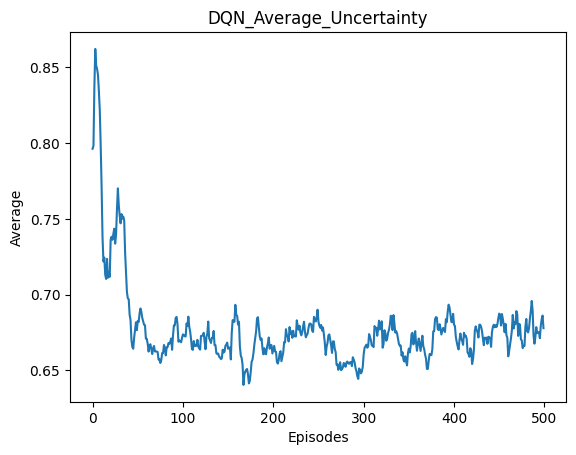

In [ ]:
import random
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from UAVenv import UAVEnv

class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出 en:deque

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer en: Add data to the buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size  en: Sample data from the buffer
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量 en: Get the current size of the buffer
        return len(self.buffer)

class Qnet(torch.nn.Module):

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数  en: Use ReLU activation function for hidden layer
        x = F.relu(self.fc2(x))  # 隐藏层使用ReLU激活函数  en: Use ReLU activation function for hidden layer
        return self.fc3(x)

class DQN:
    ''' DQN算法 '''
    # en: Deep Q-Network
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络 en: Q-network
        # 目标网络 en: Target network
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器 en: Use Adam optimizer
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子 en: Discount factor
        self.epsilon = epsilon  # epsilon-贪婪策略 en: Epsilon-greedy strategy
        self.target_update = target_update  # 目标网络更新频率 en: Target network update frequency
        self.count = 0  # 计数器,记录更新次数 en: Counter to track update steps
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作 en: Take action using epsilon-greedy strategy
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        min_epsilon = 0
        self.epsilon = max(min_epsilon, self.epsilon * 0.995)  # epsilon衰减 en: Epsilon decay
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值 en: Q-values
        # 下个状态的最大Q值 en: Max Q-value for next state
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values  # TD误差目标 en: TD error target
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数 en: Mean Squared Error loss function
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0 en: The default gradient in PyTorch accumulates, and here it needs to be explicitly set to 0
        dqn_loss.backward()  # 反向传播更新参数 en: Backpropagation to update parameters
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络 en: Update target network
        self.count += 1

    def save(self, path):
        """保存模型参数"""
        # en: Save model parameters
        model_state = {
            'q_net': self.q_net.state_dict(),
            'target_q_net': self.target_q_net.state_dict(),
            'optimizer': self.optimizer.state_dict()
        }
        torch.save(model_state, path)
        
    def load(self, path):
        """加载模型参数"""
        # en: Load model parameters
        model_state = torch.load(path)
        self.q_net.load_state_dict(model_state['q_net'])
        self.target_q_net.load_state_dict(model_state['target_q_net']) 
        self.optimizer.load_state_dict(model_state['optimizer'])

lr = 1e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.95
epsilon = 1
target_update = 100
buffer_size = 2000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env = UAVEnv()
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.state_dim
action_dim = env.action_dim
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
return_list_2=[]
steps_per_episode = []  # 添加新列表来记录每轮的步数 en: List to record the number of steps per episode
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            step_count = 0  # 初始化步数计数器 en: Initialize step count

            while not done:
                step_count += 1  # 每执行一步操作，步数加1 en: Increment step count for each action taken
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练 en: Only train Q-network when the buffer has enough data
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            return_list_2.append(sum(sum(env.uncertainty_matrix))/100)
            steps_per_episode.append(step_count)  # 记录该轮的总步数 en: Record the total steps for this episode
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:]),
                    'uncertainty_matrix':
                    '%.3f' % np.mean(return_list_2[-10:]),
                    'avg_steps': 
                    '%.1f' % np.mean(steps_per_episode[-10:])  # 显示最近10轮的平均步数 en: Show the average steps for the last 10 episodes
                })
            pbar.update(1)

# 训练完成后保存模型
# en: Save the model after training
agent.save('dqn_model.pth')

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN_Returns')
plt.show()
episodes_list = list(range(len(return_list_2)))
plt.plot(episodes_list, return_list_2)
plt.xlabel('Episodes')
plt.ylabel('Average Uncertainty')
plt.title('DQN_Average_Uncertainty')
plt.show()

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.title('DQN_Returns')
plt.show()
mv_return = moving_average(return_list_2, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Average')
plt.title('DQN_Average_Uncertainty')
plt.show()


In [26]:
import pickle

# 保存 
# en:Save
with open("dqn_returns.pkl", "wb") as f:
    pickle.dump((return_list, return_list_2), f)

# 读取
# en:Load
with open("dqn_returns.pkl", "rb") as f:
    return_list, return_list_2 = pickle.load(f)